### Build Changepoint detection model on TAQ Trades with adaptive penalties 

In [1]:
import pandas as pd 
import numpy as np
from scipy.sparse import dia_matrix, csc_matrix
from scipy.sparse.linalg import inv
import matplotlib.pyplot as plt
from datetime import datetime
import sys
from scipy.interpolate import interp1d
from scipy.stats import iqr
import ruptures as rpt
from sklearn.model_selection import train_test_split
import time




path='/home/jbohn/jupyter/personal/'
sys.path.append(f'{path}TAQ-Query-Scripts/data')
sys.path.append(f'{path}Changepoint_LOB/Lasso/CPD')
from adaptive_tf_ir import l1tf_adaptive_ir, Dmat

### TAQ Data AAPL

Snippet of AAPL trades on NYSE for 1 hour

In [2]:
trades=pd.read_csv(f'{path}TAQ-Query-Scripts/data/cleaned_trades.csv',index_col=0)

trades=trades[trades.index < "2020-01-02 09:31:30"]
trades=trades[trades.index> "2020-01-02 09:30:30"]

trades['Trade_Price']=np.log(trades['Trade_Price'])
trades

,SIP_Timestamp,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,Trade_Reporting_Facility,Trade_Through_Exempt_Indicator,date
2020-01-02 09:30:30.020361,2020-01-02 09:30:30.020381,Q,AAPL,100,5.689447,@,N,0,32529,2652,,0,2020-01-02
2020-01-02 09:30:30.020924,2020-01-02 09:30:30.021119,Z,AAPL,103,5.689447,@,N,0,32532,272,,0,2020-01-02
2020-01-02 09:30:30.021038,2020-01-02 09:30:30.021056,Q,AAPL,34,5.689447,@ I,N,0,32531,2653,,0,2020-01-02
2020-01-02 09:30:30.022665,2020-01-02 09:30:30.022861,Z,AAPL,35,5.689447,@F I,N,0,32533,273,,1,2020-01-02
2020-01-02 09:30:30.069102,2020-01-02 09:30:30.069302,Z,AAPL,15,5.689481,@ I,N,0,32539,274,,0,2020-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 09:31:29.309155,2020-01-02 09:31:29.309179,Q,AAPL,100,5.689210,@,N,0,47075,3104,,0,2020-01-02
2020-01-02 09:31:29.309155,2020-01-02 09:31:29.309184,Q,AAPL,100,5.689210,@,N,0,47076,3105,,0,2020-01-02
2020-01-02 09:31:29.310312,2020-01-02 09:31:29.310683,C,AAPL,100,5.689041,@,N,0,47079,11,,0,2020-01-02
2020-01-02 09:31:29.441711,2020-01-02 09:31:29.442087,A,AAPL,100,5.689109,@,N,0,47093,14,,0,2020-01-02


Text(0.5, 1.0, 'APPL Trade Price 01/15/2020')

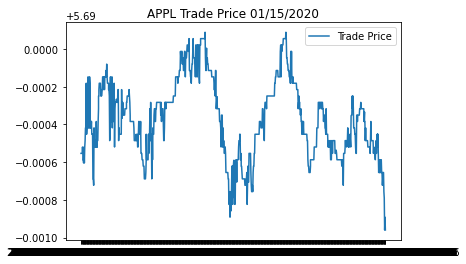

In [3]:
fig,ax=plt.subplots()
ax.plot(trades['Trade_Price'],label='Trade Price')
ax.legend()
ax.set_title("APPL Trade Price 01/15/2020")

In [4]:
vol=trades['Trade_Volume']

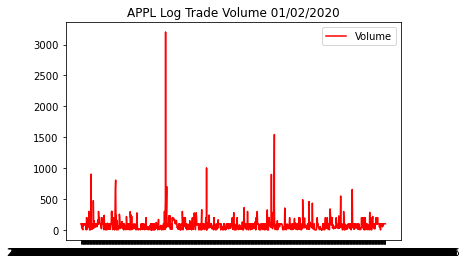

In [5]:
fig,ax=plt.subplots()
ax.set_title("APPL Log Trade Volume 01/02/2020")
ax.plot(vol,color='red',label='Volume')
ax.legend()

### Extension for irregularly spaced time and Adaptive Penalty

### Unit Test 1

For both unit tests we pass in an array of differences in time 

For each trend filtering problem, the filtered signal is returned with the normalized D_DT Inverse



In [6]:
t=np.arange(0,len(trades.index))
t1=np.cumsum(np.pad(np.diff(t),(1,0),'constant',constant_values=t[1]))

In [7]:

y=trades['Trade_Price'].values.reshape(-1,1)

x_adapt1,status,eq_D=l1tf_adaptive_ir(y,lambda_p=10)

pobj1: [[24438.26401971]], pobj2: [[0.55602572]], dobj: [[0.]], gap: [[0.55602572]]
pobj1: [[3.81741583e+17]], pobj2: [[0.05860878]], dobj: [[9.67199403e-07]], gap: [[0.05860781]]
pobj1: [[2.43284302e+14]], pobj2: [[0.00829766]], dobj: [[1.83373314e-06]], gap: [[0.00829582]]
pobj1: [[1.29463513e+11]], pobj2: [[0.00174936]], dobj: [[3.64480992e-06]], gap: [[0.00174571]]
pobj1: [[2.60574594e+08]], pobj2: [[0.00053865]], dobj: [[9.55537631e-06]], gap: [[0.0005291]]
pobj1: [[2771874.10465751]], pobj2: [[0.00010716]], dobj: [[1.80509575e-05]], gap: [[8.91128153e-05]]
pobj1: [[29829.064322]], pobj2: [[3.06536928e-05]], dobj: [[1.920617e-05]], gap: [[1.14475228e-05]]
pobj1: [[5430.11903987]], pobj2: [[2.50348313e-05]], dobj: [[2.00768146e-05]], gap: [[4.95801666e-06]]
pobj1: [[4035.46323423]], pobj2: [[2.13292203e-05]], dobj: [[2.05404148e-05]], gap: [[7.888055e-07]]
pobj1: [[4067.5148325]], pobj2: [[2.06484037e-05]], dobj: [[2.0556382e-05]], gap: [[9.20217779e-08]]
pobj1: [[4026.02115913]], 

In [8]:
print(np.linalg.cond(eq_D))
print(np.round(eq_D,4))
print(np.linalg.cond(eq_D))

187102.7851953983
[[ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]]
187102.7851953983


Note the equivalence in difference matrix

Text(0.5, 1.0, 'Adaptive Trend Filtering APPL Trade Price 01/06/2020')

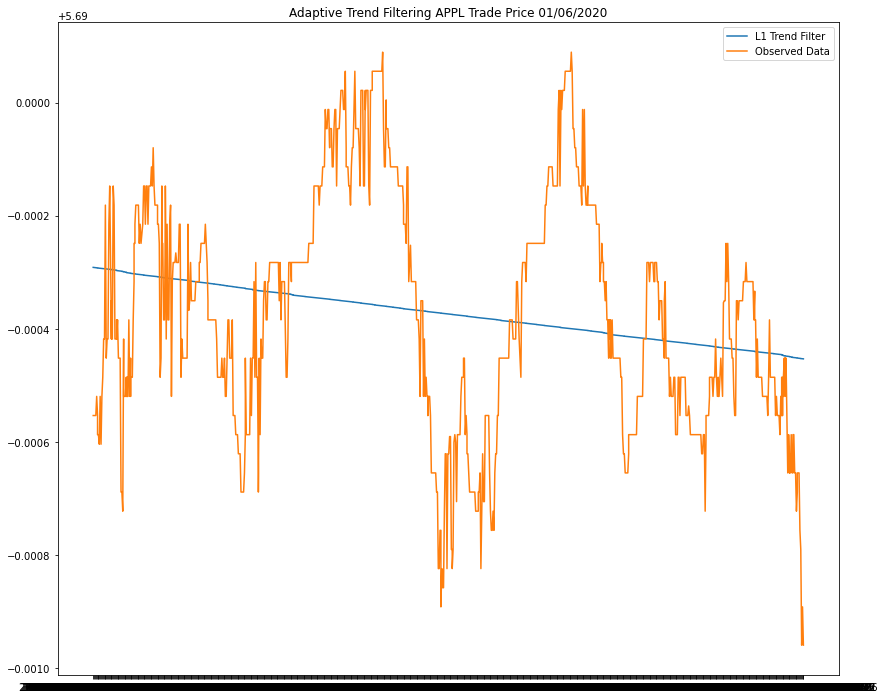

In [9]:
fig,ax=plt.subplots(figsize=(14,12))
ax.plot(trades.index,x_adapt1,label= 'L1 Trend Filter')
ax.plot(trades.index,y, label='Observed Data')


ax.legend()
ax.set_title("Adaptive Trend Filtering APPL Trade Price 01/06/2020")

### Unit Test 2

Uniformly sampled data within the range (0.999999,1.000001)

Leads me to believe the optimization is ill=conditioned 

In [10]:
a=.9
b=1.1

t2=np.cumsum(np.random.rand(len(y))*(b-a)+a)

t2

array([   1.08127243,    1.99948806,    2.99602264, ..., 1020.73555974,
       1021.70117804, 1022.79177514])

In [11]:

y=trades['Trade_Price'].values.reshape(-1,1)

x_adapt2,status,D_2=l1tf_adaptive_ir(y,t=t2,lambda_p=1.0)

pobj1: [[12193.19274725]], pobj2: [[0.22255893]], dobj: [[0.]], gap: [[0.22255893]]
pobj1: [[3.82745988e+17]], pobj2: [[0.03552928]], dobj: [[8.30430386e-07]], gap: [[0.03552845]]
pobj1: [[2.46842782e+14]], pobj2: [[0.00495029]], dobj: [[1.62164896e-06]], gap: [[0.00494867]]
pobj1: [[1.45613972e+11]], pobj2: [[0.0009718]], dobj: [[3.07427355e-06]], gap: [[0.00096873]]
pobj1: [[3.8814308e+08]], pobj2: [[0.00027937]], dobj: [[6.87821405e-06]], gap: [[0.00027249]]
pobj1: [[16604740.39023207]], pobj2: [[0.00010274]], dobj: [[1.60113841e-05]], gap: [[8.67269954e-05]]
pobj1: [[518339.54976519]], pobj2: [[3.49155239e-05]], dobj: [[1.86731639e-05]], gap: [[1.624236e-05]]
pobj1: [[18733.05456609]], pobj2: [[2.31985971e-05]], dobj: [[1.92600946e-05]], gap: [[3.9385025e-06]]
pobj1: [[5547.57963247]], pobj2: [[2.19141051e-05]], dobj: [[1.98478621e-05]], gap: [[2.06624305e-06]]
pobj1: [[3764.59921019]], pobj2: [[2.09524051e-05]], dobj: [[2.04029166e-05]], gap: [[5.49488523e-07]]
pobj1: [[4503.68484

In [12]:
print(np.round(D_2,4))

print(np.linalg.matrix_rank(D_2),D_2.shape)
print(np.linalg.cond(D_2))

[[ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]]
1021 (1021, 1023)
187102.7851953983


### Unit Test 3

In [13]:
a=0
b=2

t3=np.cumsum(np.random.rand(len(trades.index))*(b-a)+a)


t3

array([   1.61351636,    2.62750346,    4.4677342 , ..., 1026.89098511,
       1028.20463881, 1029.27045704])

In [14]:


y=trades['Trade_Price'].values.reshape(-1,1)

x_adapt3,status,D_3=l1tf_adaptive_ir(y,t=t3,lambda_p=1)

pobj1: [[23320.45033125]], pobj2: [[0.74508724]], dobj: [[0.]], gap: [[0.74508724]]
pobj1: [[3.83293249e+17]], pobj2: [[0.04455642]], dobj: [[8.60468025e-07]], gap: [[0.04455556]]
pobj1: [[2.47732512e+14]], pobj2: [[0.00554777]], dobj: [[1.66273893e-06]], gap: [[0.00554611]]
pobj1: [[1.47619129e+11]], pobj2: [[0.00108351]], dobj: [[3.1639786e-06]], gap: [[0.00108034]]
pobj1: [[4.30312534e+08]], pobj2: [[0.00031833]], dobj: [[7.24131101e-06]], gap: [[0.00031109]]
pobj1: [[18693698.3058597]], pobj2: [[0.00011213]], dobj: [[1.62607819e-05]], gap: [[9.5873784e-05]]
pobj1: [[532083.53152203]], pobj2: [[3.62924714e-05]], dobj: [[1.87099207e-05]], gap: [[1.75825507e-05]]
pobj1: [[20590.51275735]], pobj2: [[2.36695516e-05]], dobj: [[1.9287075e-05]], gap: [[4.38247663e-06]]
pobj1: [[6589.29142409]], pobj2: [[2.21866735e-05]], dobj: [[1.98808962e-05]], gap: [[2.30577733e-06]]
pobj1: [[4195.68930294]], pobj2: [[2.11299743e-05]], dobj: [[2.03992318e-05]], gap: [[7.30742543e-07]]
pobj1: [[5116.0386

In [15]:
print(np.round(D_3,4))

print(np.linalg.matrix_rank(D_3),D_3.shape)
print(np.linalg.cond(D_3))

[[ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]]
1021 (1021, 1023)
187102.7851953983


In [16]:
a=0
b=10

t4=np.cumsum(np.random.rand(len(trades.index))*(b-a)+a)


t4

array([   8.66174985,   15.8648656 ,   20.67800377, ..., 5107.09959474,
       5108.0443536 , 5109.91538639])

In [17]:

y=trades['Trade_Price'].values.reshape(-1,1)

x_adapt4,status,D_4=l1tf_adaptive_ir(y,t=t4,lambda_p=1)

pobj1: [[23587.70207406]], pobj2: [[0.41536577]], dobj: [[0.]], gap: [[0.41536577]]
pobj1: [[3.82321705e+17]], pobj2: [[0.04663377]], dobj: [[9.01319908e-07]], gap: [[0.04663287]]
pobj1: [[2.45052925e+14]], pobj2: [[0.00639077]], dobj: [[1.72286778e-06]], gap: [[0.00638905]]
pobj1: [[1.47632852e+11]], pobj2: [[0.00130981]], dobj: [[3.35654003e-06]], gap: [[0.00130645]]
pobj1: [[5.01557036e+08]], pobj2: [[0.00038789]], dobj: [[7.9061774e-06]], gap: [[0.00037998]]
pobj1: [[16819971.01632613]], pobj2: [[0.00012528]], dobj: [[1.67086539e-05]], gap: [[0.00010857]]
pobj1: [[382754.48371171]], pobj2: [[3.69348663e-05]], dobj: [[1.88074989e-05]], gap: [[1.81273674e-05]]
pobj1: [[19724.1666045]], pobj2: [[2.45804098e-05]], dobj: [[1.9374972e-05]], gap: [[5.2054378e-06]]
pobj1: [[8548.56644172]], pobj2: [[2.27729736e-05]], dobj: [[2.00179669e-05]], gap: [[2.75500669e-06]]
pobj1: [[10107.90793]], pobj2: [[2.2021823e-05]], dobj: [[2.02773373e-05]], gap: [[1.74448562e-06]]
pobj1: [[11060.31699773]]

In [18]:
print(np.round(D_4,4))

print(np.linalg.matrix_rank(D_4),D_4.shape)
print(np.linalg.cond(D_4))

[[ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]]
1021 (1021, 1023)
187102.7851953983


Text(0.5, 0.98, 'Adaptive Trend Filtering APPL Trade Price 01/06/2020')

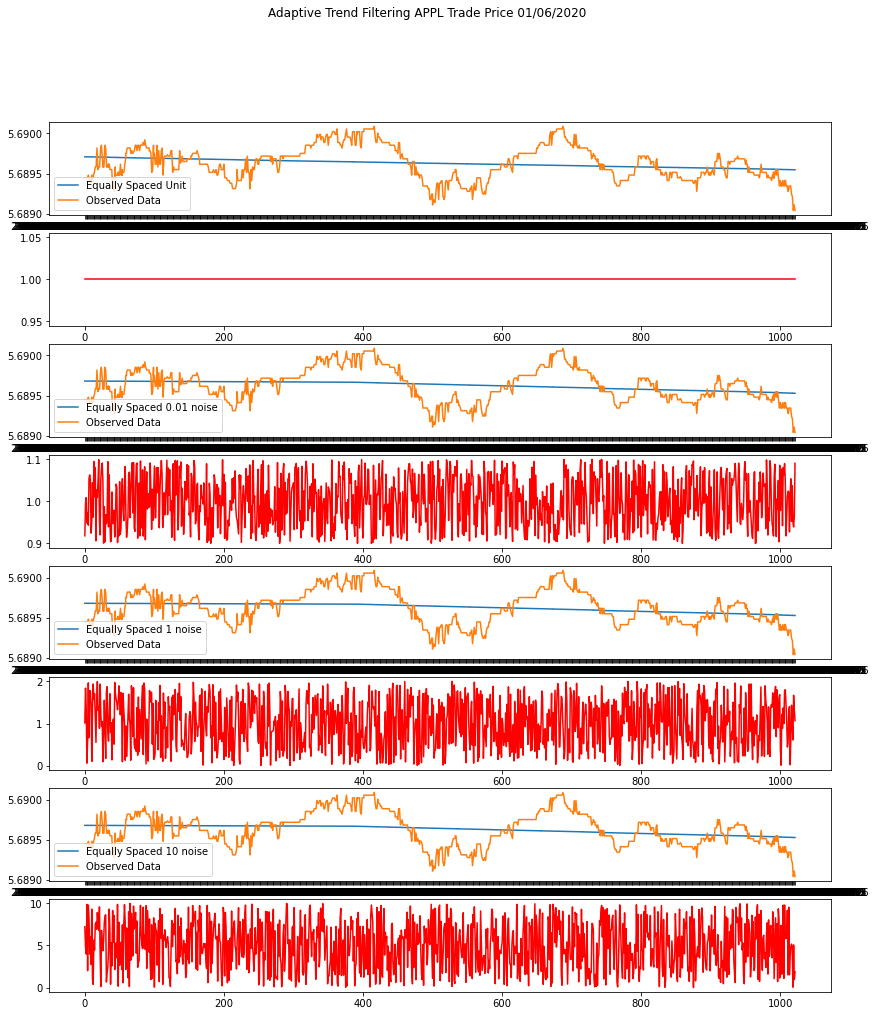

In [19]:
fig,ax=plt.subplots(8,1,figsize=(14,16))
ax[0].plot(trades.index,x_adapt1,label= 'Equally Spaced Unit')
ax[0].plot(trades.index,y, label='Observed Data')

ax[1].plot(np.diff(t1),color='red')

ax[2].plot(trades.index,x_adapt2,label= 'Equally Spaced 0.01 noise')
ax[2].plot(trades.index,y, label='Observed Data')

ax[3].plot(np.diff(t2),color='red')

ax[4].plot(trades.index,x_adapt3,label= 'Equally Spaced 1 noise')
ax[4].plot(trades.index,y, label='Observed Data')

ax[5].plot(np.diff(t3),color='red')

ax[6].plot(trades.index,x_adapt4,label= 'Equally Spaced 10 noise')
ax[6].plot(trades.index,y, label='Observed Data')

ax[7].plot(np.diff(t4),color='red')

ax[0].legend()
ax[2].legend()
ax[4].legend()
ax[6].legend()

fig.suptitle("Adaptive Trend Filtering APPL Trade Price 01/06/2020")

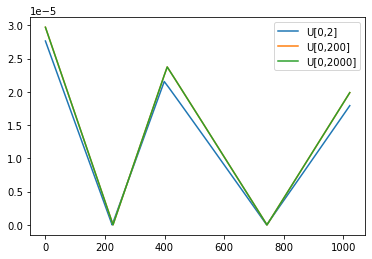

In [20]:
plt.plot(abs(x_adapt1-x_adapt2),label='U[0,2]')
plt.plot(abs(x_adapt1-x_adapt3),label='U[0,200]')
plt.plot(abs(x_adapt1-x_adapt3),label='U[0,2000]')
plt.legend()

### Unit Test factoring of irregular timesteps

Adjust our penalty by the time factor

Unit test by applying an extremely large time difference with white noise time differences all around

In [21]:
a=0.99
b=1.01

t_unit=np.concatenate([((np.random.rand(100))*(b-a)+a),((np.random.rand(2))*(b-a)+a)*2000*np.ones(2),((np.random.rand(len(y)-102))*(b-a)+a)])
t_unit

array([0.99747248, 0.99360176, 0.9909354 , ..., 1.00127927, 0.99263975,
       0.99194114])

In [22]:
y=trades['Trade_Price'].values.reshape(-1,1)

x_adapt5,status,D_5=l1tf_adaptive_ir(y,t=t_unit,lambda_p=.01)

pobj1: [[29563.05137824]], pobj2: [[0.78593066]], dobj: [[0.]], gap: [[0.78593066]]
pobj1: [[3.85258374e+17]], pobj2: [[0.04006604]], dobj: [[8.11773939e-07]], gap: [[0.04006523]]
pobj1: [[2.49658151e+14]], pobj2: [[0.00434778]], dobj: [[1.56838636e-06]], gap: [[0.00434621]]
pobj1: [[1.90730295e+11]], pobj2: [[0.00082399]], dobj: [[2.91947121e-06]], gap: [[0.00082107]]
pobj1: [[2.44269713e+09]], pobj2: [[0.00023717]], dobj: [[5.94652188e-06]], gap: [[0.00023122]]
pobj1: [[1.71409974e+08]], pobj2: [[0.00012628]], dobj: [[1.20519514e-05]], gap: [[0.00011423]]
pobj1: [[17659716.43561229]], pobj2: [[6.06919511e-05]], dobj: [[1.68154281e-05]], gap: [[4.3876523e-05]]
pobj1: [[1823728.98282037]], pobj2: [[3.13785881e-05]], dobj: [[1.84620636e-05]], gap: [[1.29165246e-05]]
pobj1: [[2594471.55117212]], pobj2: [[2.69975772e-05]], dobj: [[1.87795418e-05]], gap: [[8.21803539e-06]]
pobj1: [[3280833.43253628]], pobj2: [[2.42738335e-05]], dobj: [[1.89653954e-05]], gap: [[5.30843806e-06]]
pobj1: [[102

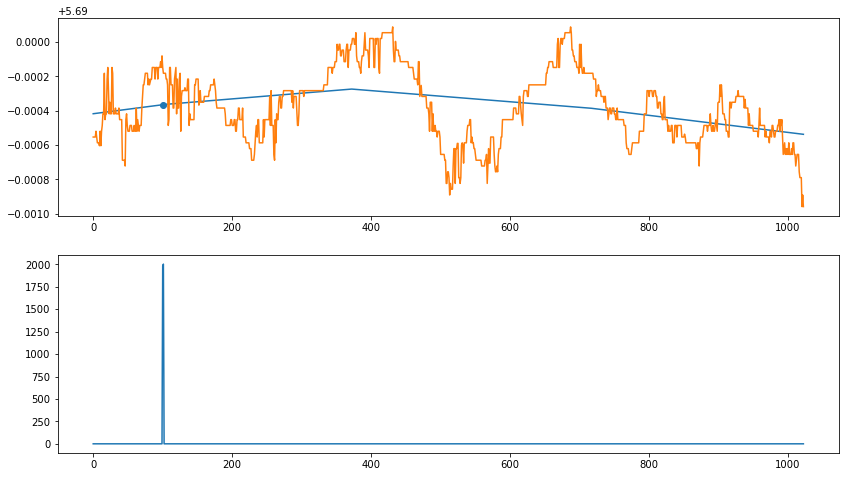

In [23]:
fig,ax=plt.subplots(2,1,figsize=(14,8))
ax[0].plot(np.arange(0,len(y)),x_adapt5,label= 'Equally Spaced Unit')
ax[0].plot(np.arange(0,len(y)),y, label='Observed Data')
ax[0].scatter(100,x_adapt5[100])
ax[1].plot (t_unit)